In [1]:
import pandas as pd
import numpy as np

## Reading some buckets of sales data 

In [2]:
train_data1 = pd.read_csv('../data/interim/train_2013-11_to_2014-12.csv', parse_dates=['date'])
val_data1 = pd.read_csv('../data/interim/val_2015-1.csv', parse_dates=['date'])

train_data2 = pd.read_csv('../data/interim/train_2013-1_to_2015-4.csv', parse_dates=['date'])
val_data2 = pd.read_csv('../data/interim/val_2015-5.csv', parse_dates=['date'])

train_data3 = pd.read_csv('../data/interim/train_2013-6_to_2015-6.csv', parse_dates=['date'])
val_data3 = pd.read_csv('../data/interim/val_2015-7.csv', parse_dates=['date'])

train_data4 = pd.read_csv('../data/interim/train_2013-3_to_2015-7.csv', parse_dates=['date'])
val_data4 = pd.read_csv('../data/interim/val_2015-8.csv', parse_dates=['date'])

### And additional tables

In [3]:
shops = pd.read_csv('../data/interim/shops_appearence.csv', parse_dates=['shop_appearence'])
items = pd.read_csv('../data/interim/items_appearence.csv', parse_dates=['item_appearence'])
item_cat = pd.read_csv('../data/interim/item_categories_global.csv')
sales_pivot = pd.read_csv('../data/interim/sales_pivot.csv')
datasets = {'shops': shops, 'items': items, 'item_categories': item_cat, 'sales_lags': sales_pivot}

## Feature extraction

I decided to define feature extraction layer as a pipeline that modifies initial data step by step. Here ate the steps:

1) getting `month` from `date` and encoding it

2) merging with `items`, `shops` and `item_categories` tables to add information (such as `city`, `item_category` and `global_category` features)

3) calculating how long both item and shop are present in dataset

4) grouping by month and calculating montly sales feature, our target

5) adding previous month sales (1, 3, 6 and 12 month ago)


In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [5]:
class MonthFromDate(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None ):
        return self
    def transform(self, X, y=None):
        X['month'] = X['date_block_num'] % 12 + 1
        X['month_sin'] = np.sin(2 * np.pi * X['month']/12.0)
        X['month_cos'] = np.cos(2 * np.pi * X['month']/12.0)
        X.drop(['month'], axis=1, inplace=True) 
#        print('Month encoding stage complete')
        return X
    
class ShopItemAge(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None ):
        return self
    def transform(self, X, y=None):
        X['shop_age_month'] = (X['date'] - X['shop_appearence']).dt.days / 30
        X['item_age_month'] = (X['date'] - X['item_appearence']).dt.days / 30
        X.drop(['shop_appearence','item_appearence','date'], axis=1, inplace=True) 

#        print('Item and shop ages calculation complete')
        return X
    
class MonthlySales(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None ):
        return self
    def transform(self, X, y=None):
        X = X.groupby(['date_block_num','item_id', 'shop_id']).agg({'item_cnt_day':'sum',
                                                                    'date':'max',
                                                                   }).reset_index().rename({'item_cnt_day':'item_cnt_month'}, axis=1)
#        print('Monthly sales calculated')
        
        return X

class MergeTables(BaseEstimator, TransformerMixin):
    def __init__(self, lookup_tables):
        self.items = lookup_tables['items']
        self.shops = lookup_tables['shops']
        self.item_cat = lookup_tables['item_categories']
        self.sales_lags = lookup_tables['sales_lags']
    def fit(self, X, y=None ):
        return self
    def transform(self, X, y=None):
        X = X.merge(self.items, on='item_id', how='left')
        X = X.merge(self.shops, on='shop_id', how='left')
        X = X.merge(self.item_cat, on='item_category_id', how='left')
        X = X.merge(self.sales_lags, on=['item_id', 'shop_id'], how='left')
        X['item_appearence'] = X['item_appearence'].fillna(X['date'])
        X['shop_appearence'] = X['shop_appearence'].fillna(X['date'])
        X = X.fillna(0)
        X.drop(['item_name', 'shop_name', 'item_category_name', 'city', 'global_cat'], axis=1, inplace=True)
#        print('Merging stage complete')
        return X

extraction_steps = [("montly_sales", MonthlySales()),
                ("month_feat", MonthFromDate()),
                ("merge", MergeTables(datasets)),
                ("ages", ShopItemAge())
            ]
        
feature_extraction_pipeline = Pipeline(steps=extraction_steps)

In [6]:
class GetLagSales(BaseEstimator, TransformerMixin):
    def __init__(self, lags):
        self.lags = lags
    def fit(self, X, y=None ):
        return self
    def transform(self, X, y=None):
        date_block = X['date_block_num'].iloc[0]
        for lag in self.lags:
            if date_block - lag >= 0:
                X[f'month_lag_{lag}'] = X.loc[:, str(int(date_block-lag))]
            else:
                X[f'month_lag_{lag}'] = 0
        return X
    
class GetSumOfSales(BaseEstimator, TransformerMixin):
    def __init__(self, lags):
        self.lags = lags
    def fit(self, X, y=None ):
        return self
    def transform(self, X, y=None):
        date_block = X['date_block_num'].iloc[0]
        for lag in self.lags:
            cols_to_sum = [str(int(date_block-i)) for i in range(1, lag + 1) if date_block-i >= 0]
            X[f'sum_sales_lag_{lag}'] = X.loc[:,cols_to_sum].sum(axis=1)
        X.drop([str(i) for i in range(34)], axis=1, inplace=True)
        X.drop(['date_block_num'], axis=1, inplace=True)
        return X
    
    
lag_steps = [("past_month_sales", GetLagSales([1,2,3,6,12])),
                ("summed_sales", GetSumOfSales([6,12]))
            ]
        
lag_pipeline = Pipeline(steps=lag_steps)

### Choosing best training data subset

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

from tqdm.notebook import tqdm
from datetime import datetime

In [8]:
def x_y_split(df, target):
    return df.drop(target, axis=1), df[target]

In [9]:
def compare_models(models):
    result = []
    fold = 1

    with tqdm(total=(len(models) + 1) * 4) as pbar:
        for val, train in zip([val_data1, val_data2, val_data3, val_data4], [train_data1, train_data2, train_data3, train_data4]):

            train = feature_extraction_pipeline.fit_transform(train)
            train_per_month = [lag_pipeline.fit_transform(train.loc[train['date_block_num'] == block].copy()) for block in train['date_block_num'].unique()]
            train = pd.concat(train_per_month, axis=0)
            
            val = feature_extraction_pipeline.transform(val)
            val = lag_pipeline.transform(val)
            
            pbar.update(1)

            val_x, val_y = x_y_split(val, 'item_cnt_month')
            train_x, train_y = x_y_split(train, 'item_cnt_month')

            for model_name, model in models.items():
                fit_time_start = datetime.now()
                model.fit(train_x, train_y)
                fit_time_end = datetime.now()
                result.append({'model' : model_name,
                               'fold' : fold,
                               'data_size' : train_x.shape[0],
                               'fit_time' : (fit_time_end - fit_time_start).seconds,
                               'val_mse' : mean_squared_error(val_y, model.predict(val_x)),
                               'train_mse' : mean_squared_error(train_y, model.predict(train_x))})
                pbar.update(1)
            fold += 1
            
    return result

In [10]:
model_dict = {'RFR' : RandomForestRegressor(max_depth=15, n_jobs=-1, random_state=1001),
             #'KNN': KNeighborsRegressor(),
             'XGBR':XGBRegressor(n_jobs=-1, random_state=1001),
             'LR':LinearRegression()
             }

result_df = pd.DataFrame(compare_models(model_dict))
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,model,fold,data_size,fit_time,val_mse,train_mse
0,RFR,1,684153,106,81.291316,7.533512
1,XGBR,1,684153,19,96.807124,9.432227
2,LR,1,684153,0,64.915778,30.647533
3,RFR,2,1415112,233,82.437034,11.019005
4,XGBR,2,1415112,44,80.275704,11.262223
5,LR,2,1415112,0,78.167511,32.026592
6,RFR,3,1184316,196,13.238854,10.064671
7,XGBR,3,1184316,38,9.784373,11.995038
8,LR,3,1184316,0,6.782828,36.791826
9,RFR,4,1389648,231,8.630072,10.339162


In [11]:
import seaborn as sns

def plot_results(result_df):
    sns.set(rc={'figure.figsize':(11,8)})
    tmp1 = result_df.drop(['val_mse'], axis=1).rename(columns={'train_mse' : 'mse'})
    tmp1['type'] = 'train'
    tmp2 = result_df.drop(['train_mse'], axis=1).rename(columns={'val_mse' : 'mse'})
    tmp2['type'] = 'val'
    sns.lineplot(data=tmp1.append(tmp2), x='fold', y='mse', hue='model', style='type');

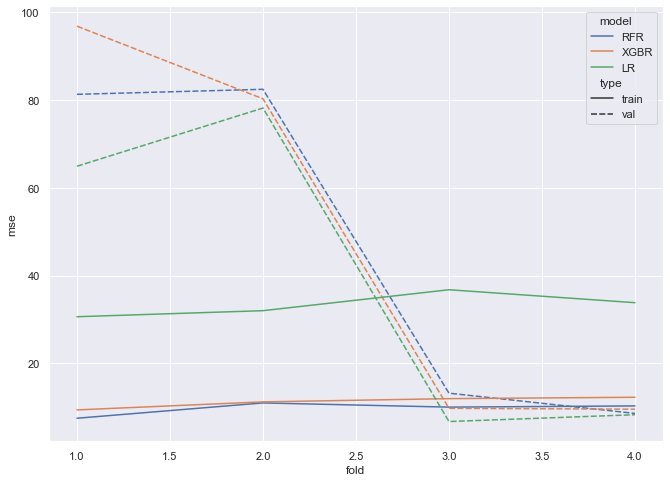

In [12]:
plot_results(result_df)

We can observe overfitting in many cases (except for maybe RFR, XGBR on folds 3-4,). 

All models except for LR performed significantly better on fold 3 and 4.

For now we will choose fold 3 for further experiments, since it's smaller than 4.

Also RFR is significantly slower to train.

## Experiments

In [13]:
train = feature_extraction_pipeline.fit_transform(train_data3)
train_per_month = [lag_pipeline.fit_transform(train.loc[train['date_block_num'] == block].copy()) for block in train['date_block_num'].unique()]
train = pd.concat(train_per_month, axis=0)

val = feature_extraction_pipeline.transform(val_data3)
val = lag_pipeline.transform(val)

train.to_csv('../data/processed/train_experimental.csv', index=False)
val.to_csv('../data/processed/val_experimental.csv', index=False) 
    
target = 'item_cnt_month'
val_x, val_y = x_y_split(val, target)
train_x, train_y = x_y_split(train, target)

In [14]:
train_x.head()

,item_id,shop_id,month_sin,month_cos,item_category_id,city_id,global_cat_id,shop_age_month,item_age_month,month_lag_1,month_lag_2,month_lag_3,month_lag_6,month_lag_12,sum_sales_lag_6,sum_sales_lag_12
0,27,25,1.224647e-16,-1.0,19,15,5,5.600000,5.600000,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,27,32,1.224647e-16,-1.0,19,15,5,5.166667,5.166667,0.0,0.0,1.0,0.0,0.0,1.0,1.0
2,28,28,1.224647e-16,-1.0,30,15,8,5.700000,5.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,28,30,1.224647e-16,-1.0,30,15,8,5.000000,5.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,28,47,1.224647e-16,-1.0,30,24,8,5.066667,5.066667,0.0,0.0,0.0,0.0,0.0,3.0,3.0


In [15]:
train_y_original = train_y
val_y_original = val_y

### Baseline XGBR

In [16]:
xgbr = XGBRegressor(n_jobs=-1, random_state=1001, max_depth=6)
xgbr.fit(train_x, train_y)
train_mse = mean_squared_error(train_y, xgbr.predict(train_x))
val_pred = xgbr.predict(val_x)
val_mse = mean_squared_error(val_y, val_pred)
train_mse, val_mse

(11.995037825527362, 9.784373441228656)

In [17]:
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

num_cols = ['shop_age_month', 'item_age_month', 'month_lag_1', 'month_lag_2','month_lag_3', 'month_lag_6', 'month_lag_12', 'sum_sales_lag_6', 'sum_sales_lag_12']
cat_cols = ['shop_id', 'item_id', 'item_category_id', 'global_cat_id', 'city_id']

def markov_probability_tresh(data, prob=0.03):
    return np.mean(data) / prob

In [18]:
def transform_train(train_x, train_y, val_x, val_y, 
                   scale=True, 
                   remove_outliars=True, 
                   trim_val=False, 
                   log_transform=True,
                   encode_cat=True):

    t_x = train_x.copy()
    v_x = val_x.copy()
    t_y = train_y.copy()
    v_y = val_y.copy()

    res_transformers = {}
    
    if remove_outliars:
        threshold = markov_probability_tresh(t_y, 0.03)
        t_x = t_x[t_y < threshold].copy()
        t_y = t_y[t_y < threshold].copy()
        if trim_val:
            v_x = v_x[v_y < threshold].copy()
            v_y = v_y[v_y < threshold].copy()
    
    if log_transform:
        t_y = np.log(t_y)
        v_y = np.log(v_y)
        
    target_scaler = None
    
    if scale:
        feature_scaler = StandardScaler()
        t_x[num_cols] = feature_scaler.fit_transform(t_x[num_cols])
        v_x[num_cols] = feature_scaler.transform(v_x[num_cols])
        res_transformers['feature_scaler'] = feature_scaler
        
        target_scaler = StandardScaler()
        t_y = target_scaler.fit_transform(t_y.values.reshape(-1, 1))
        v_y = target_scaler.transform(v_y.values.reshape(-1, 1))
        res_transformers['target_scaler'] = target_scaler
    
    encoder = None
    if encode_cat:
        encoder  = ce.TargetEncoder(min_samples_leaf=1, smoothing=1.0)
        t_x[cat_cols] = t_x[cat_cols].astype(object) 
        t_x[cat_cols] = encoder.fit_transform(t_x[cat_cols], t_y)
        v_x[cat_cols] = encoder.transform(v_x[cat_cols])
        res_transformers['cat_encoder'] = encoder
    
    res_data = {'t_x': t_x, 't_y': t_y, 'v_x': v_x, 'v_y': v_y}
        
    return res_data, res_transformers

### Standard scaling numerical data

In [19]:
data, transformers = transform_train(train_x, train_y, val_x, val_y, 
                   scale=True, 
                   remove_outliars=False, 
                   trim_val=False, 
                   log_transform=False,
                   encode_cat=False)

t_x, t_y, v_x = data['t_x'], data['t_y'], data['v_x']
target_scaler = transformers['target_scaler']

In [20]:
xgbr = XGBRegressor(n_jobs=-1, random_state=1001, max_depth=7)
xgbr.fit(t_x, t_y)
train_mse = mean_squared_error(train_y_original, target_scaler.inverse_transform(xgbr.predict(t_x)))
val_pred = xgbr.predict(v_x)
val_mse = mean_squared_error(val_y_original, target_scaler.inverse_transform(val_pred))
train_mse, val_mse

(9.051796644171676, 9.839380930216073)

### Target log transform

In [21]:
data, transformers = transform_train(train_x, train_y, val_x, val_y, 
                   scale=False, 
                   remove_outliars=False, 
                   trim_val=False, 
                   log_transform=True,
                   encode_cat=False)
t_x, t_y, v_x = data['t_x'], data['t_y'], data['v_x']

In [22]:
#unscaled log target
xgbr = XGBRegressor(n_jobs=-1, random_state=1001, max_depth=14)
xgbr.fit(t_x, t_y)
train_mse = mean_squared_error(train_y_original, np.exp(xgbr.predict(t_x)))
val_pred = xgbr.predict(v_x)
val_mse = mean_squared_error(val_y_original, np.exp(val_pred))
train_mse, val_mse

(4.97338110847008, 5.8022994749748165)

In [23]:
data, transformers = transform_train(train_x, train_y, val_x, val_y, 
                   scale=True, 
                   remove_outliars=False, 
                   trim_val=False, 
                   log_transform=True,
                   encode_cat=False)

t_x, t_y, v_x = data['t_x'], data['t_y'], data['v_x']
target_scaler = transformers['target_scaler']

In [24]:
#scaled log target
xgbr = XGBRegressor(n_jobs=-1, random_state=1001, max_depth=14)
xgbr.fit(t_x, t_y)
train_pred = np.exp(target_scaler.inverse_transform(xgbr.predict(t_x)))
train_mse = mean_squared_error(train_y_original, train_pred)
val_pred = np.exp(target_scaler.inverse_transform(xgbr.predict(v_x)))
val_mse = mean_squared_error(val_y_original, val_pred)
train_mse, val_mse

(5.206646101025826, 6.987958143259265)

### Categorical encoding (mean target)

In [25]:
data, transformers = transform_train(train_x, train_y, val_x, val_y, 
                   scale=False, 
                   remove_outliars=False, 
                   trim_val=False, 
                   log_transform=False,
                   encode_cat=True)

t_x, t_y, v_x = data['t_x'], data['t_y'], data['v_x']

C:\Users\masha\anaconda3\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\masha\anaconda3\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [26]:
xgbr = XGBRegressor(n_jobs=-1, random_state=1001, max_depth=5)
xgbr.fit(t_x, t_y)
train_mse = mean_squared_error(train_y_original, xgbr.predict(t_x))
val_mse = mean_squared_error(val_y_original, xgbr.predict(v_x))
train_mse, val_mse

(8.193778961832107, 7.629037121875277)

In [27]:
data, transformers = transform_train(train_x, train_y, val_x, val_y, 
                   scale=True, 
                   remove_outliars=False, 
                   trim_val=False, 
                   log_transform=True,
                   encode_cat=True)

t_x, t_y, v_x = data['t_x'], data['t_y'], data['v_x']
target_scaler = transformers['target_scaler']

C:\Users\masha\anaconda3\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\masha\anaconda3\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [28]:
# + scale + log
xgbr = XGBRegressor(n_jobs=-1, random_state=1001, max_depth=12)
xgbr.fit(t_x, t_y)
train_pred = np.exp(target_scaler.inverse_transform(xgbr.predict(t_x)))
train_mse = mean_squared_error(train_y_original, train_pred)
val_pred = np.exp(target_scaler.inverse_transform(xgbr.predict(v_x)))
val_mse = mean_squared_error(val_y_original, val_pred)
train_mse, val_mse

(5.377578430723077, 5.20669657486861)

### Outliar treatment

In [29]:
data, transformers = transform_train(train_x, train_y, val_x, val_y, 
                   scale=False, 
                   remove_outliars=True, 
                   trim_val=False, 
                   log_transform=False,
                   encode_cat=False)

t_x, t_y, v_x = data['t_x'], data['t_y'], data['v_x']

In [30]:
# kept outliars in val
xgbr = XGBRegressor(n_jobs=-1, random_state=1001, max_depth=13)
xgbr.fit(t_x, t_y)
train_mse = mean_squared_error(t_y, xgbr.predict(t_x))
val_mse = mean_squared_error(val_y_original, xgbr.predict(v_x))
train_mse, val_mse

(1.0537071907603588, 20.89767506077039)

In [31]:
data, transformers = transform_train(train_x, train_y, val_x, val_y, 
                   scale=False, 
                   remove_outliars=True, 
                   trim_val=True, 
                   log_transform=False,
                   encode_cat=False)

t_x, t_y, v_x, v_y = data['t_x'], data['t_y'], data['v_x'], data['v_y']

In [32]:
# remove outliars from val
xgbr = XGBRegressor(n_jobs=-1, random_state=1001, max_depth=7)
xgbr.fit(t_x, t_y)
train_mse = mean_squared_error(t_y, xgbr.predict(t_x))
val_mse = mean_squared_error(v_y, xgbr.predict(v_x))
train_mse, val_mse
#sub1 - public score 2.39917

(3.853058628655512, 5.637215005656683)

### Combined

In [43]:
data, transformers = transform_train(train_x, train_y, val_x, val_y, 
                   scale=True, 
                   remove_outliars=True, 
                   trim_val=True, 
                   log_transform=True,
                   encode_cat=True)

t_x, t_y, v_x, v_y = data['t_x'], data['t_y'], data['v_x'], data['v_y']
target_scaler = transformers['target_scaler']
encoder = transformers['cat_encoder']
feature_scaler = transformers['feature_scaler']

C:\Users\masha\anaconda3\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\masha\anaconda3\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [44]:
xgbr = XGBRegressor(n_jobs=-1, random_state=1001, max_depth=4)
xgbr.fit(t_x, t_y)
train_pred = np.exp(target_scaler.inverse_transform(xgbr.predict(t_x)))
train_mse = mean_squared_error(t_y, train_pred)
val_pred = np.exp(target_scaler.inverse_transform(xgbr.predict(v_x)))
val_mse = mean_squared_error(v_y, val_pred)
train_mse, val_mse
#sub2 - public score 1.53485

(5.958485657319335, 8.307904344705834)

# Test processing and submission

In [34]:
from datetime import date

class MonthlySalesTest(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None ):
        return self
    def transform(self, X, y=None):
        X['date_block_num'] = 34
        X['date'] = date(2015, 34 % 12 + 1, 30)
        X['date'] = pd.to_datetime(X['date'], format="%Y-%m-%d")
        return X

pipeline_steps_test = extraction_steps
pipeline_steps_test[0] = ("montly_sales", MonthlySalesTest())

feature_extraction_pipeline_test = Pipeline(steps=pipeline_steps_test)

In [35]:
def transform_test(test_x,
                   scale=True, 
                   feature_scaler=None,  
                   encode_cat=True,
                   encoder=None):

    t_x = test_x.copy()
    
    if scale:
        t_x[num_cols] = feature_scaler.fit_transform(t_x[num_cols])

    if encode_cat:
        t_x[cat_cols] = t_x[cat_cols].astype(object) 
        t_x[cat_cols] = encoder.transform(t_x[cat_cols])
        
    return t_x

In [36]:
test = pd.read_csv('../data/interim/test_etl.csv', index_col='ID')

In [37]:
test_x = feature_extraction_pipeline_test.fit_transform(test)
test_x = lag_pipeline.transform(test_x)
test_x.head()

,shop_id,item_id,month_sin,month_cos,item_category_id,city_id,global_cat_id,shop_age_month,item_age_month,month_lag_1,month_lag_2,month_lag_3,month_lag_6,month_lag_12,sum_sales_lag_6,sum_sales_lag_12
0,5,5037,-0.5,0.866025,19,5,5,34.166667,14.833333,0.0,1.0,3.0,1.0,1.0,7.0,12.0
1,5,5320,-0.5,0.866025,55,5,12,34.166667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,-0.5,0.866025,19,5,5,34.166667,7.700000,1.0,3.0,1.0,3.0,0.0,10.0,10.0
3,5,5232,-0.5,0.866025,23,5,5,34.166667,3.733333,0.0,0.0,1.0,0.0,0.0,1.0,1.0
4,5,5268,-0.5,0.866025,20,5,5,34.166667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
t_x = transform_test(test_x,
                   scale=True,
                   feature_scaler=feature_scaler,
                   encode_cat=True,
                   encoder=encoder)

In [47]:
y_test = np.exp(target_scaler.inverse_transform(xgbr.predict(t_x)))
#y_test = xgbr.predict(t_x)
y_test = pd.DataFrame(y_test, columns=['item_cnt_month']).reset_index()
y_test.to_csv('../data/processed/sub_exp2.csv', header=['ID', 'item_cnt_month'], index=False)
y_test

,index,item_cnt_month
0,0,1.527719
1,1,0.741723
2,2,1.725369
3,3,0.938917
4,4,0.809662
...,...,...
214195,214195,1.467490
214196,214196,1.084314
214197,214197,1.086013
214198,214198,1.041405
